# HW5 - Semantic Influence Networks

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
#All these packages need to be installed from pip
#This will be doing most of the work
import networkx as nx
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics
import pickle #if you want to save layouts
import os
%matplotlib inline

In [109]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Reading data

In [3]:
reddit_submissions_min= pandas.read_csv('../project_data/reddit_submissions_2015_18.csv', index_col=6)[['author', 'created_utc', 'subreddit', 'title', 'selftext', 'distinguished']]

In [4]:
reddit_submissions_min['created_datetime'] = pandas.to_datetime(reddit_submissions_min['created_utc'], unit='s')

In [28]:
reddit_submissions_min['created_tranche'] = pandas.cut(reddit_submissions_min['created_utc'], bins = 20, labels = list(range(20)))

In [32]:
reddit_submissions_min[reddit_submissions_min['subreddit'] == 'The_Donald']['created_tranche'].value_counts(sort = False)

0        0
1        9
2       64
3      740
4     5724
5     2858
6     3033
7     3410
8     4870
9     3457
10    3357
11    3051
12    3026
13    2729
14    2867
15    3147
16    1809
17    2118
18     797
19    1026
Name: created_tranche, dtype: int64

I'll work with Tranche 8 of the 'r/The_Donald' subreddit.

In [137]:
reddit_submissions_min_select = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald') & (reddit_submissions_min['created_tranche'] == 8)]
reddit_submissions_min_select.head()

,author,created_utc,subreddit,title,selftext,distinguished,created_datetime,created_tranche
id,,,,,,,,
58cvsk,Daddydante88,1476911906,The_Donald,It Is Perfectly Legal For The Media To Lie To ...,"I find it funny that the ""most transparent adm...",NaN,2016-10-19 21:18:26,8
58cz8j,-StrangerThanFiction,1476912944,The_Donald,Why doesn't Bernie just endorse Trump and disa...,With Trump's new student loan forgiveness and ...,NaN,2016-10-19 21:35:44,8
58czfz,ULTRADETH,1476913006,The_Donald,I'm Canadian and want to watch be debate tonig...,"I have: NBC, CBS, PBS, CNN (yeah right), FOX, ...",NaN,2016-10-19 21:36:46,8
58d18m,xXTheCitrusReaperXx,1476913581,The_Donald,Is this 4 Chan thing happening?,Last night someone said that something Earth-c...,NaN,2016-10-19 21:46:21,8
58d1zt,giovanni10487,1476913831,The_Donald,Is michelle obama a man?,I am just hearing about this now. Joan rivers ...,NaN,2016-10-19 21:50:31,8


In [138]:
print("Min date in Tranche 9: {}, Max date in Tranche 8: {}".format(min(reddit_submissions_min_select['created_datetime']), max(reddit_submissions_min_select['created_datetime'])))  

Min date in Tranche 9: 2016-10-19 21:18:26, Max date in Tranche 8: 2016-12-21 13:28:14


In [139]:
reddit_submissions_min_select['post_text'] = reddit_submissions_min_select['title'] + " " + reddit_submissions_min_select['selftext']
reddit_submissions_min_select['tokenized_sents'] = reddit_submissions_min_select['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_min_select['normalized_sents'] = reddit_submissions_min_select['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [140]:
with open('reddit_submissions_min_select_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_min_select, f)

## Exercise 1 - 

Tasks:
- Network construction:
    - Reply networks
    - Entity references
    - Hyperlinks
- What filters and thresholds do I use? Interrogate subgraphs

In [141]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g
    
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [142]:
g = wordCooccurrence(reddit_submissions_min_select['normalized_sents'].sum())

In [143]:
len(g.nodes)

26079

In [144]:
len(g.edges)

685591

In [146]:
nx.write_graphml(g, 'reddit_donald_t8.graphml')

In [147]:
redVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
redVects_incidence = redVectorizer.fit_transform(reddit_submissions_min_select['post_text'])

In [148]:
redVects_incidence.shape

(4870, 25879)

In [149]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((redVectorizer.get_feature_names()[i] for i in range(redVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(redVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, redVectorizer.get_feature_names()[w], {'weight' : redVects_incidence[d, w]}) for d, w in zip(*redVects_incidence.nonzero())))

In [150]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 30749
Number of edges: 205925
Average degree:  13.3939


In [151]:
with open('reddit_select_2modenet.pkl', 'wb') as f:
    pickle.dump(g_2mode, f)

### Document-Network (Submissions)

In [152]:
gDoc = contractNetwork(g_2mode, 'doc')
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 4870
Number of edges: 6550935
Average degree: 2690.3224


In [159]:
nodesHigh = [v for v, c in docnode_centrality.items() if c >= 0.026]
len(nodesHigh)

19

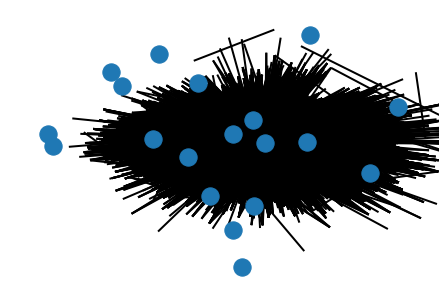

In [161]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
#wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
w90 = np.percentile([d['weight'] for n1, n2, d in gDoc.edges(data = True)], 90)
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > w90]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= w90]
#nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=nodesHigh, edgelist = edgesHigh, width=2)

In [162]:
docnode_centrality = nx.eigenvector_centrality(gDoc)

KeyboardInterrupt: 

In [58]:
print(len(reddit_submissions_min_select.iloc[2567]['post_text']),"words:","\n",reddit_submissions_min_select.iloc[2567]['post_text'].strip().replace('  ', '\n'))

13 words: 
 #FuckAudi ...


In [61]:
print(len(reddit_submissions_min_select.iloc[2669]['post_text']),"words:","\n",reddit_submissions_min_select.iloc[2669]['post_text'].strip().replace('  ', '\n'))

85 words: 
 RIP Bernie. After Loranda, he dug his own grave, jumped in, and his ghost buried him.


### Word-Network

In [ ]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

In [ ]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
word80 = np.percentile([d['weight'] for n1, n2, d in gWord.edges(data = True)], 80)
print("wMean: {}, w80%le: {}".format(wMean, word80))

In [ ]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 30])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [ ]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

In [ ]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

In [ ]:
c

In [ ]:
giant = nx.Graph(giant)

giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

In [ ]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [ ]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

In [ ]:
trumpNeighbors = giant.neighbors('trump')
g_trump = giant.subgraph(trumpNeighbors)
print(nx.info(g_trump))

In [ ]:
layout_trump = nx.spring_layout(g_trump, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_trump.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_trump.edges(data = True)))
nx.draw(g_trump, ax = ax, pos = layout_trump, labels = {n:n for n in g_trump.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_trump.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [ ]:
trumpWNeighbors = gWord.neighbors('trump')
trumpWNeighborsPlus1 = set(trumpWNeighbors)
for n in trumpWNeighbors:
    trumpWNeighborsPlus1 |= set(giant.neighbors(n))
    
for x in trumpWNeighborsPlus1:
    print(x)

In [ ]:
g_trump2 = giant.subgraph(trumpWNeighborsPlus1)
giant.remove_nodes_from(list(nx.isolates(g_trump2)))
print(nx.info(g_trump2))

In [ ]:
layout_trump2 = nx.spring_layout(g_trump2, weight='weight', iterations= 100, k = 0.6)
fig, ax = plt.subplots(figsize = (10,10))
centralities_trump2 = nx.eigenvector_centrality(g_trump2)
maxC = max(centralities_trump2.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_trump2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_trump2.edges(data = True)))
nx.draw(g_trump2, ax = ax, pos = layout_trump2, labels = {n:n for n in g_trump2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_trump2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))